Base VAE Code: https://github.com/google/flax/tree/main/examples/vae

Followed the original Theano repository of LVAE paper: https://github.com/casperkaae/LVAE

Authors gave more details about the paper in issues: https://github.com/casperkaae/LVAE/issues/1

Finally, in some parts I followed: https://github.com/AntixK/PyTorch-VAE/blob/master/models/lvae.py

PS: Importance weighting is not implemented.

Firat Oncel / oncelf@itu.edu.tr

Omniglot downlad:

In [ ]:
!wget -nc https://raw.githubusercontent.com/yburda/iwae/master/datasets/OMNIGLOT/chardata.mat

In [ ]:
from tkinter.tix import Tree
from unicodedata import name
from absl import app
from absl import flags
from typing import Any

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn
try:
    from probml_utils import savefig
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig

from flax.training import train_state, checkpoints
import shutil
import jax.numpy as jnp
import jax
from jax import random
import typing
from typing import Any
from typing import Sequence
import numpy as np

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds


import scipy.io
import os
import math
import PIL
from PIL import Image
import matplotlib.pyplot as plt

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"

This code is created with reference to torchvision/utils.py. Modify: torch.tensor -> jax.numpy.DeviceArray If you want to know about this file in detail, please visit the original code: https://github.com/pytorch/vision/blob/master/torchvision/utils.py

In [ ]:
def save_image(ndarray, nrow=8, padding=2, pad_value=0.0, format=None):

    if not (
        isinstance(ndarray, jnp.ndarray)
        or (isinstance(ndarray, list) and all(isinstance(t, jnp.ndarray) for t in ndarray))
    ):
        raise TypeError("array_like of tensors expected, got {}".format(type(ndarray)))

    ndarray = jnp.asarray(ndarray)

    if ndarray.ndim == 4 and ndarray.shape[-1] == 1:  # single-channel images
        ndarray = jnp.concatenate((ndarray, ndarray, ndarray), -1)

    # make the mini-batch of images into a grid
    nmaps = ndarray.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(ndarray.shape[1] + padding), int(ndarray.shape[2] + padding)
    num_channels = ndarray.shape[3]
    grid = jnp.full((height * ymaps + padding, width * xmaps + padding, num_channels), pad_value).astype(jnp.float32)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            grid = grid.at[y * height + padding : (y + 1) * height, x * width + padding : (x + 1) * width].set(
                ndarray[k]
            )
            k = k + 1

    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = jnp.clip(grid * 255.0 + 0.5, 0, 255).astype(jnp.uint8)
    new_arr = np.asarray(ndarr)
    im = Image.fromarray(new_arr)
    plt.imshow(im)
    plt.show()

In [ ]:
mnist_dict = {"learning_rate": 1e-3, "dataset_name": "mnist"}
fashion_mnist_dict = {"learning_rate": 5e-4, "dataset_name": "fashion_mnist"}
omniglot_dict = {"learning_rate": 5e-4, "dataset_name": "omniglot"}
damping = 0.75
batch_size = 256
num_epochs = 500
load_path = None
num_layers = 5
nt = 200
save_every = 25
# Taken from paper
latent_dim = [64, 32, 16, 8, 4]
hidden_dim = [512, 256, 128, 64, 32]
input_dim = 28 * 28

In [ ]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [ ]:
class Encoder(nn.Module):
    hidden_dim: int
    latent_dim: int

    @nn.compact
    def __call__(self, x, train):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        x = nn.BatchNorm(not train, name="bn1")(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_dim, name="fc2")(x)
        x = nn.BatchNorm(not train, name="bn2")(x)
        x = nn.leaky_relu(x)
        mean_x = nn.Dense(self.latent_dim, name="fc_m")(x)
        logvar_x = nn.Dense(self.latent_dim, name="fc_var")(x)

        return x, mean_x, jnp.clip(nn.softplus(logvar_x), 0, 10)

In [ ]:
class Ladder(nn.Module):
    hidden_dim: int
    latent_dim: int

    @nn.compact
    def __call__(self, x, train):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        x = nn.BatchNorm(not train, name="bn1")(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_dim, name="fc2")(x)
        x = nn.BatchNorm(not train, name="bn2")(x)
        x = nn.leaky_relu(x)
        mean_x = nn.Dense(self.latent_dim, name="fc_m")(x)
        logvar_x = nn.Dense(self.latent_dim, name="fc_var")(x)
        return mean_x, jnp.clip(nn.softplus(logvar_x), 0, 10)

In [ ]:
class Decoder(nn.Module):
    hidden_dim: int

    @nn.compact
    def __call__(self, x, train):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        x = nn.BatchNorm(not train, name="bn1")(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(self.hidden_dim, name="fc2")(x)
        x = nn.BatchNorm(not train, name="bn2")(x)
        x = nn.leaky_relu(x)
        return x

In [ ]:
class Final(nn.Module):
    hidden_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim, name="fc1")(x)
        return nn.sigmoid(x)

In [ ]:
class LVAE(nn.Module):
    latent_dims: Sequence[int]
    hidden_dims: Sequence[int]
    input_dim: int

    def setup(self):
        self.num_rungs = len(self.latent_dims)

        assert len(self.latent_dims) == len(self.hidden_dims), "Length of the latent" "and hidden dims must be the same"
        # Build Encoder
        modules = []
        for i, h_dim in enumerate(self.hidden_dims):
            modules.append(Encoder(h_dim, self.latent_dims[i]))
        self.encoders = modules

        # Build Decoder
        modules = []
        for i in range(self.num_rungs - 2, -1, -1):
            modules.append(Ladder(self.hidden_dims[i], self.latent_dims[i]))
        modules.append(Decoder(self.hidden_dims[0]))
        self.decoders = modules

        # Final layer
        self.final = Final(self.input_dim)

    def __call__(self, x, key_list, train, z=None, generate=False):
        encoded, decoded, m_s = [], [], []
        num_layers = self.num_rungs
        # First layer
        d, m, s = self.encoders[0](x, train)
        encoded.append((d, m, s))

        for i in range(1, num_layers):
            d, m, s = self.encoders[i](d, train)
            encoded.append((d, m, s))

        if not generate:
            for i in range(num_layers - 1):
                z = reparameterize(key_list[i], m, s)
                _, mu, sigma = encoded[num_layers - 2 - i]
                mu_dec, sigma_dec = self.decoders[i](z, train)
                m, s = merge_gauss(mu, mu_dec, sigma, sigma_dec)
                decoded.append((mu_dec, sigma_dec))
                m_s.append((m, s))

            z = reparameterize(key_list[-1], m, s)
            dec = self.decoders[-1](z, train)
            p_x = self.final(dec)

        else:
            for i in range(num_layers - 1):
                mu_dec, sigma_dec = self.decoders[i](z, train)
                z = reparameterize(key_list[i], mu_dec, sigma_dec)
            dec = self.decoders[-1](z, train)
            p_x = self.final(dec)

        all_mu_sigma = []  # To calculate KL Divergence
        if not generate:
            _, mu_enc_last, sigma_enc_last = encoded[-1]
            all_mu_sigma.append((mu_enc_last, sigma_enc_last))
            all_mu_sigma.append((0.0, 1.0))  # Standard normal

            for i in range(len(m_s)):
                all_mu_sigma.append(m_s[i])  # Merged
                all_mu_sigma.append(decoded[i])  # Decoder outputs

        return p_x, all_mu_sigma

In [ ]:
def merge_gauss(mu_1, mu_2, log_var_1, log_var_2):
    p_1 = 1.0 / (jnp.exp(log_var_1) + 1e-7)
    p_2 = 1.0 / (jnp.exp(log_var_2) + 1e-7)
    mu = (mu_1 * p_1 + mu_2 * p_2) / (p_1 + p_2)
    log_var = jnp.log(1.0 / (p_1 + p_2))
    return mu, log_var

In [ ]:
def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

In [ ]:
@jax.jit
def kl_divergence(q_params, p_params):
    mu_q, log_var_q = q_params
    mu_p, log_var_p = p_params
    kl = (log_var_p - log_var_q) + (jnp.exp(log_var_q) + (mu_q - mu_p) ** 2) / (2 * jnp.exp(log_var_p) + 1e-6) - 0.5
    kl = jnp.sum(kl, axis=-1)
    return kl.mean()

In [ ]:
@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = jnp.log(logits + 1e-6)
    return -jnp.sum(labels * logits + (1.0 - labels) * jnp.log(-jnp.expm1(logits)))

In [ ]:
def compute_metrics(recon_x, x, kl_list):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = 0
    for i in range(0, len(kl_list), 2):
        kld_loss += kl_divergence(kl_list[i], kl_list[i + 1])

    return {"bce": bce_loss, "kld": kld_loss, "loss": bce_loss + kld_loss}

In [ ]:
def model(latent_dim, hidden_dim, input_dim):
    return LVAE(latent_dim, hidden_dim, input_dim)

In [ ]:
@jax.jit
def train_step(state, batch, key_list, kl_weight):
    def loss_fn(params, batch_stats):
        recon_x, kl_list = model(latent_dim, hidden_dim, input_dim).apply(
            {"params": params, "batch_stats": batch_stats}, batch, key_list, False
        )
        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = 0
        for i in range(0, len(kl_list), 2):
            kld_loss += kl_divergence(kl_list[i], kl_list[i + 1])

        loss = bce_loss + kl_weight * kld_loss
        return loss

    grads = jax.grad(loss_fn)(state.params, state.batch_stats)
    return state.apply_gradients(grads=grads)

In [ ]:
@jax.jit
def eval(params, batch_stats, images, z, key_list):
    def eval_model(vae):

        recon_images, kl_list = vae(images, key_list, False)
        comparison = jnp.concatenate([images[:16].reshape(-1, 28, 28, 1), recon_images[:16].reshape(-1, 28, 28, 1)])
        generated_images, _ = vae(images, key_list, False, z, True)
        generated_images = generated_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, kl_list)

        return metrics, comparison, generated_images

    return nn.apply(eval_model, model(latent_dim, hidden_dim, input_dim))(
        {"params": params, "batch_stats": batch_stats}
    )

In [ ]:
def prepare_image(x):
    x = tf.cast(x["image"], tf.float32)
    x = tf.reshape(x, (-1,))

    return x / 255

In [ ]:
def prepare_dataset(dataset_name, batch_size):
    if dataset_name.startswith("omni"):
        omni_raw = scipy.io.loadmat("chardata.mat")
        train_data = np.array(omni_raw["data"].T.astype("float32"))
        test_data = np.array(omni_raw["testdata"].T.astype("float32"))
        train_ds = tf.data.Dataset.from_tensor_slices(train_data)
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(train_data.shape[0])
        train_ds = train_ds.batch(batch_size)
        train_ds = iter(tfds.as_numpy(train_ds))
        test_ds = tf.data.Dataset.from_tensor_slices(test_data).batch(test_data.shape[0])
        test_ds = np.array(list(test_ds)[0])
        test_ds = jax.device_put(test_ds)
        train_size = train_data.shape[0]

    elif dataset_name.startswith("mni"):
        ds_builder = tfds.builder("mnist")
        ds_builder.download_and_prepare()
        train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
        train_ds = train_ds.map(prepare_image)
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(50000)
        train_ds = train_ds.batch(batch_size)
        train_ds = iter(tfds.as_numpy(train_ds))
        test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
        test_ds = test_ds.map(prepare_image).batch(10000)
        test_ds = np.array(list(test_ds)[0])
        test_ds = jax.device_put(test_ds)
        train_size = 50000
    elif dataset_name.startswith("fash"):
        ds_builder = tfds.builder("fashion_mnist")
        ds_builder.download_and_prepare()
        train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
        train_ds = train_ds.map(prepare_image)
        train_ds = train_ds.cache()
        train_ds = train_ds.repeat()
        train_ds = train_ds.shuffle(50000)
        train_ds = train_ds.batch(batch_size)
        train_ds = iter(tfds.as_numpy(train_ds))
        test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
        test_ds = test_ds.map(prepare_image).batch(10000)
        test_ds = np.array(list(test_ds)[0])
        test_ds = jax.device_put(test_ds)
        train_size = 50000

    return train_ds, test_ds, train_size

In [ ]:
def main(exp_dict):
    learning_rate = exp_dict["learning_rate"]
    dataset_name = exp_dict["dataset_name"]

    # Make sure tf does not allocate gpu memory.
    tf.config.experimental.set_visible_devices([], "GPU")
    rng = random.PRNGKey(0)
    init_key_list = []
    rng, key = random.split(rng)
    for _ in range(num_layers):
        rng, key = random.split(rng)
        init_key_list.append(key)

    train_ds, test_ds, train_size = prepare_dataset(dataset_name, batch_size)

    print("Number of train samples:", train_size)

    # Sampling z for evaluation
    eval_keys = []
    for _ in range(num_layers + 1):
        rng, key = random.split(rng)
        eval_keys.append(key)

    z = random.normal(eval_keys.pop(), (64, latent_dim[-1]))
    rng, key = random.split(rng)

    # Initialization
    init_data = random.uniform(key, (batch_size, input_dim), jnp.float32, -0.05, 0.05)
    total_steps = num_epochs * (train_size // batch_size) + num_epochs

    # LR Scheduler
    piecewise_constant_decay_scheduler = optax.piecewise_constant_schedule(
        init_value=learning_rate,
        boundaries_and_scales={
            int(total_steps * 0.1): damping,
            int(total_steps * 0.2): damping,
            int(total_steps * 0.3): damping,
            int(total_steps * 0.4): damping,
            int(total_steps * 0.5): damping,
            int(total_steps * 0.6): damping,
            int(total_steps * 0.7): damping,
            int(total_steps * 0.8): damping,
            int(total_steps * 0.9): damping,
        },
    )

    optimizer = optax.adam(learning_rate=piecewise_constant_decay_scheduler)

    # Creating train state
    rng, key = random.split(rng)
    state = TrainState.create(
        apply_fn=model(latent_dim, hidden_dim, input_dim).apply,
        params=model(latent_dim, hidden_dim, input_dim).init(key, init_data, init_key_list, True, z, False)["params"],
        tx=optimizer,
        batch_stats=model(latent_dim, hidden_dim, input_dim).init(key, init_data, init_key_list, True, z, False)[
            "batch_stats"
        ],
    )

    if load_path is not None:
        state = checkpoints.restore_checkpoint(ckpt_dir=load_path, target=state)
        print("Loaded from checkpoint!")

    steps_per_epoch = train_size // batch_size
    kl_weight = 0
    warm_up = 1 / nt

    for epoch in range(num_epochs):
        for _ in range(steps_per_epoch):
            key_list = []
            batch = next(train_ds)
            for _ in range(num_layers):
                rng, key = random.split(rng)
                key_list.append(key)
            state = train_step(state, batch, key_list, kl_weight)

        kl_weight += warm_up
        kl_weight = min(1, kl_weight)

        if not ((epoch + 1) % save_every):
            metrics, comparison, sample = eval(state.params, state.batch_stats, test_ds, z, eval_keys)
            print(
                "eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}".format(
                    epoch + 1, metrics["loss"], metrics["bce"], metrics["kld"]
                )
            )
            if epoch + 1 == num_epochs:
                save_image(comparison, nrow=16)
                save_image(sample, nrow=16)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Number of train samples: 50000
eval epoch: 25, loss: 168.5342, BCE: 63.0598, KLD: 105.4744
eval epoch: 50, loss: 137.9575, BCE: 66.2254, KLD: 71.7321
eval epoch: 75, loss: 124.7530, BCE: 69.3428, KLD: 55.4102
eval epoch: 100, loss: 117.7395, BCE: 72.3862, KLD: 45.3534
eval epoch: 125, loss: 113.7366, BCE: 74.9316, KLD: 38.8050
eval epoch: 150, loss: 111.8119, BCE: 76.5078, KLD: 35.3041
eval epoch: 175, loss: 110.5554, BCE: 78.0352, KLD: 32.5202
eval epoch: 200, loss: 109.9553, BCE: 80.2538, KLD: 29.7015
eval epoch: 225, loss: 109.5024, BCE: 79.4809, KLD: 30.0215
eval epoch: 250, loss: 109.2625, BCE: 80.4123, KLD: 28.8501
eval epoch: 275, loss: 108.8212, BCE: 79.7398, KLD: 29.0814
eval epoch: 300, loss: 108.6366, BCE: 79.4850, KLD: 29.1516
eval epoch: 325, loss: 108.4265, BCE: 79.4662, KLD: 28.9603
eval epoch: 350, loss: 108.3445, BCE: 79.8699, KLD: 28.4746
eval epoch:

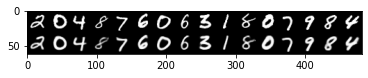

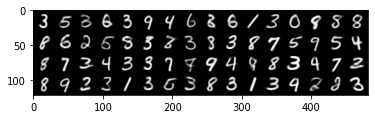

In [ ]:
main(mnist_dict)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2TXXTI/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2TXXTI/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Number of train samples: 50000
eval epoch: 25, loss: 277.9286, BCE: 216.7530, KLD: 61.1756
eval epoch: 50, loss: 260.0067, BCE: 216.7073, KLD: 43.2995
eval epoch: 75, loss: 252.6209, BCE: 218.1791, KLD: 34.4418
eval epoch: 100, loss: 249.3030, BCE: 219.7867, KLD: 29.5163
eval epoch: 125, loss: 246.9963, BCE: 220.9972, KLD: 25.9991
eval epoch: 150, loss: 245.6965, BCE: 222.5772, KLD: 23.1192
eval epoch: 175, loss: 244.7735, BCE: 223.3629, KLD: 21.4106
eval epoch: 200, loss: 244.4016, BCE: 224.5442, KLD: 19.8574
eval epoch: 225, loss: 244.1679, BCE: 225.1086, KLD: 19.0593
eval epoch: 250, loss: 243.9687, BCE: 224.3791, KLD: 19.5896
eval epoch: 275, loss: 243.6929, BCE: 224.6925, KLD: 19.0004
eval epoch: 300, loss: 243.5842, BCE: 224.6075, KLD: 18.9767
eval epoch: 325, loss: 243.5537, BCE: 224.2490, KLD: 19.3047
eval epoch: 350, loss: 243.4431, BCE: 224.24

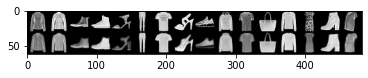

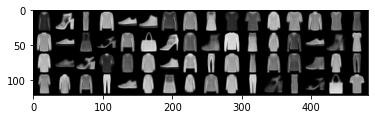

In [ ]:
main(fashion_mnist_dict)

Number of train samples: 24345
eval epoch: 25, loss: 205.9442, BCE: 80.7324, KLD: 125.2118
eval epoch: 50, loss: 173.0699, BCE: 82.3096, KLD: 90.7603
eval epoch: 75, loss: 157.6246, BCE: 86.0767, KLD: 71.5479
eval epoch: 100, loss: 148.7567, BCE: 90.9123, KLD: 57.8445
eval epoch: 125, loss: 143.3184, BCE: 94.5159, KLD: 48.8025
eval epoch: 150, loss: 140.0756, BCE: 98.2680, KLD: 41.8076
eval epoch: 175, loss: 138.1540, BCE: 101.4476, KLD: 36.7064
eval epoch: 200, loss: 137.2294, BCE: 105.6944, KLD: 31.5350
eval epoch: 225, loss: 136.5943, BCE: 104.2408, KLD: 32.3535
eval epoch: 250, loss: 136.3358, BCE: 105.8063, KLD: 30.5295
eval epoch: 275, loss: 136.0621, BCE: 104.4986, KLD: 31.5634
eval epoch: 300, loss: 135.9718, BCE: 105.2400, KLD: 30.7317
eval epoch: 325, loss: 135.7987, BCE: 104.4629, KLD: 31.3358
eval epoch: 350, loss: 135.6864, BCE: 104.8219, KLD: 30.8644
eval epoch: 375, loss: 135.4615, BCE: 104.7266, KLD: 30.7349
eval epoch: 400, loss: 135.4405, BCE: 104.8456, KLD: 30.5949
e

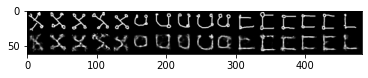

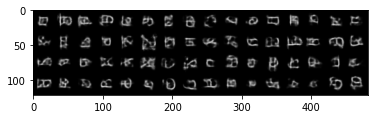

In [ ]:
main(omniglot_dict)